**Equipe:**

Juliana Pirolla 12925709

Bruna Gongora Bariccatti 12674933

Isabela Clementino Ponciano Ferreira Costa dos Santos 14654207

# Trabalho Prático 1

Este trabalho foi desenvolvido no contexto da disciplina SME0510 – Introdução à Pesquisa Operacional, cujo objetivo é aplicar os conceitos teóricos de otimização inteira na modelagem e resolução de um problema real descrito na literatura científica. O artigo escolhido para análise e implementação é “Modelos de localização para avaliação e proposição de casas de convivência para idosos no Rio de Janeiro”, apresentado no LVI Simpósio Brasileiro de Pesquisa Operacional. O estudo propõe o uso de modelos clássicos de localização (P-Mediana e P-Centro) para avaliar a atual distribuição das Casas de Convivência mantidas pela Prefeitura do Rio de Janeiro e sugerir novas localizações que melhorem o atendimento à população idosa. 
Nessa etapa, iremos complementar o projeto 1 ao analisarmos o problema agora numa abordagem que propõe a resolução do problema relaxado, bem como a proposição de uma heurística baseada em relaxação.

## Introdução

O envelhecimento populacional tem se consolidado como um dos maiores desafios sociais contemporâneos, refletindo transformações demográficas profundas em escala global e nacional. No Brasil, o Censo Demográfico de 2022 revela que a proporção de pessoas com mais de 65 anos atingiu 10,9% da população, um aumento de 57,4% em relação a 2010. No município do Rio de Janeiro, essa realidade é ainda mais expressiva, com 121,4 idosos para cada 100 jovens de até 14 anos. Esse cenário demanda a formulação de políticas públicas voltadas à promoção do envelhecimento saudável, inclusão social e qualidade de vida para a população idosa.

Diante dessa conjuntura, o artigo “Modelos de localização para avaliação e proposição de Casas de Convivência para idosos no Rio de Janeiro” propõe uma análise detalhada da infraestrutura existente para atendimento a esse público, com foco nas Casas de Convivência mantidas pela Prefeitura por meio da Secretaria Municipal do Envelhecimento Saudável e Qualidade de Vida (SEMESQV). O estudo busca compreender a distribuição espacial das unidades e dos seus frequentadores, avaliando a equidade territorial do acesso e sugerindo novas localizações com base em modelos de Pesquisa Operacional (PO), especificamente os modelos P-Mediana e P-Centro.

O problema abordado é, portanto, a desigualdade socioespacial na oferta de equipamentos públicos voltados à população idosa, uma questão que passa a dimensão geográfica e atinge diretamente a justiça social e o direito à cidade. A localização inadequada das Casas de Convivência implica barreiras de acessibilidade e exclusão, sobretudo para idosos que dependem de deslocamentos curtos e seguros. Assim, o trabalho investiga como modelos matemáticos de otimização podem auxiliar gestores públicos na tomada de decisão, propondo a abertura de novas unidades de forma racional e baseada em dados.

O artigo dialoga com diversos trabalhos relacionados, tanto nacionais quanto internacionais, que exploram a aplicação da Pesquisa Operacional em contextos sociais. Entre eles, destacam-se os estudos de Bittencourt et al. (2022) e De Armas et al. (2021), que aplicam modelos de localização para otimizar serviços de cuidado a idosos na Espanha, e os de Miranda et al. (2016a, 2016b), que analisam o envelhecimento populacional e a qualidade de vida dos idosos no Brasil. Tais referências reforçam a relevância do tema e evidenciam uma lacuna ainda existente na realidade brasileira quanto à utilização de metodologias quantitativas para embasar políticas sociais.

A importância desse problema reside na possibilidade de tornar mais eficiente e equitativa a rede de serviços públicos destinados à terceira idade. Além de sua aplicação direta à gestão urbana e ao planejamento social, o estudo demonstra como a integração entre dados geoespaciais, modelos matemáticos e ferramentas de visualização, como o aplicativo Shiny desenvolvido pelos autores, pode fortalecer a transparência e a efetividade das decisões públicas. Em um contexto de recursos limitados e demandas crescentes, a adoção de abordagens analíticas desse tipo representa um caminho promissor para o desenvolvimento de políticas baseadas em evidências, voltadas à construção de cidades mais justas, inclusivas e sensíveis às necessidades do envelhecimento populacional.

### Instalação de ferramentas

In [1]:
!pip install gurobipy numpy matplotlib


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import random
import copy
import json
import matplotlib.pyplot as plt

import gurobipy as gp
from gurobipy import GRB
from functools import partial

## Modelagem Matemática

Abordar o modelo da pág 06/12

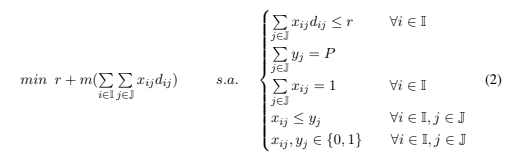

Nesta seção iremos modelar matematicamente utilizando o *solver* Gurobi o modelo apresentado no trabalho:

Dados de entrada:


$P →$ Numero de casas de convivência abertas.\
$d_{ij} →$ Distancia entre cidadão i e casa de convivência j.\
$m →$  Small-m.



Índices:

$i = 1,...., I →$ Frequentadores de casas de convivencia do Rio de Janeiro.\
$j = 1,...., J →$ Casas de convivencia existentes e potenciais.

minimizar $r + m(\sum_i\sum_jx_{ij}d_{ij} $) (1)

sujeito a:


$$\sum_{j∈J}x_{ij}d_{ij} \le r ∀ i ∈ I (2)$$
$$\sum_{j∈J}y_{j} = P (2)$$
$$\sum_{j∈J}x_{ij} = 1 ∀ i ∈ I (3)$$
$$x_{ij} \le y_{j} ∀ i ∈ I, j ∈ J (4)$$
$$x_{ij}, y_{j} ∈ {0,1} ∀ i ∈ I, j ∈ J (5)$$
$$r \le 0  (6)$$

O modelo P-Centro tem como propósito principal minimizar a distância máxima entre os idosos e as Casas de Convivência às quais eles são atendidos. Em outras palavras, o modelo busca reduzir o raio de cobertura do serviço, garantindo que todos os idosos estejam dentro de uma distância razoável de, pelo menos, uma unidade. Diferentemente do modelo P-Mediana, que prioriza a eficiência média do sistema (minimizando o deslocamento médio da população atendida), o P-Centro se preocupa com a equidade no acesso, procurando evitar que determinados grupos ou regiões fiquem desatendidos ou precisem percorrer trajetos longos.

A função objetiva (1) busca minimizar primeiro o raio máximo de atendimento r, garantindo cobertura mais justa e uniforme e secundariamente minimizar a soma total das distâncias, caso existam soluções com o mesmo raio.

As restrições do modelo exercem papéis complementares e fundamentais para que a solução seja viável e coerente com a realidade. Uma delas (2) limita o número de Casas que podem ser abertas, representando o orçamento e os recursos disponíveis da administração pública. A seguinte (3) assegura que todos os idosos sejam atendidos, ou seja, cada pessoa deve estar vinculada a exatamente uma Casa de Convivência. Também há restrições que impedem alocações incoerentes, garantindo que um idoso só possa ser designado a uma Casa que esteja efetivamente aberta (4).

Por fim, uma das restrições mais importantes determina que a distância entre cada idoso e a Casa a que ele é alocado não ultrapasse o raio máximo definido pelo modelo. É essa condição que dá sentido ao problema de P-Centro, pois ela impõe um limite de cobertura que o algoritmo tenta minimizar. Assim, o modelo busca encontrar a melhor configuração de locais para abrir novas unidades de modo que a distância mais longa entre um idoso e sua Casa seja a menor possível.

Em termos conceituais, o P-Centro reflete uma abordagem voltada à justiça espacial. Ele procura garantir que o acesso aos serviços públicos seja o mais homogêneo possível, evitando situações em que determinados bairros ou regiões fiquem excessivamente afastados das Casas de Convivência. Essa característica torna o modelo especialmente adequado para políticas sociais, nas quais a proximidade e a inclusão são mais importantes do que simplesmente otimizar custos médios.

No contexto do artigo, o uso do P-Centro permitiu propor uma distribuição geográfica mais equilibrada das novas unidades, contemplando regiões que, até então, apresentavam baixa cobertura. Desse modo, o modelo se mostrou mais eficaz para promover igualdade no acesso aos serviços, ainda que possa resultar em um aumento leve na distância média percorrida, havendo um trade-off esperado quando se busca maximizar o alcance social das políticas públicas.

### Implementação do modelo

Vamos criar uma função que recebe os dados de parâmetro e retorna o modelo do Gurobi

In [3]:
import gurobipy as gp
from gurobipy import GRB

def criarModelo(dados, instancia):
    numFrequentadores = len(dados["I"])  # número de frequentadores
    numCasas = len(dados["J"])           # número de casas

    model = gp.Model(f"Modelo_PCentro_{instancia}")

    print("- Gerando variáveis")
    x = model.addVars(numFrequentadores, numCasas, vtype=GRB.BINARY, name="x")
    y = model.addVars(numCasas, vtype=GRB.BINARY, name="y")
    r = model.addVar(vtype=GRB.CONTINUOUS, lb=0, name="r")

    print("- Gerando função objetivo")
    model.setObjective(r + dados["M"] * gp.quicksum(x[i, j] * dados["d"][i][j]for i in range(numFrequentadores)for j in range(numCasas)),GRB.MINIMIZE)

    print("- Adicionando restrições")

    # 1. Cada frequentador deve estar dentro do raio máximo r
    for i in range(numFrequentadores):model.addConstr(gp.quicksum(x[i, j] * dados["d"][i][j] for j in range(numCasas)) <= r,name=f"restr_cobertura_{i}")

    # 2. Número fixo de Casas abertas (P)
    model.addConstr(gp.quicksum(y[j] for j in range(numCasas)) == dados["P"],name="restr_num_casas")

    # 3. Cada frequentador deve ser alocado a exatamente uma Casa
    for i in range(numFrequentadores):
        model.addConstr(gp.quicksum(x[i, j] for j in range(numCasas)) == 1,name=f"restr_alocacao_{i}")

    # 4. Um frequentador só pode ser alocado a uma Casa aberta
    for i in range(numFrequentadores):
        for j in range(numCasas):
            model.addConstr(x[i, j] <= y[j],name=f"restr_dependencia_{i}_{j}")

    model.update()
    return model, x, y, r



## Geração de Instâncias

Para validar o modelo proposto e analisar o comportamento das soluções obtidas, é necessário dispor de um conjunto de instâncias representativas do problema. Seguindo a proposta do artigo “Modelos de localização para avaliação e proposição de Casas de Convivência para Idosos no Rio de Janeiro”, as instâncias devem refletir o cenário de alocação de frequentadores às casas de convivência, considerando diferentes configurações possíveis de distribuição espacial.

Como o objetivo deste trabalho é reproduzir e testar o modelo matemático de forma controlada, optou-se por gerar os dados de maneira aleatória, simulando o comportamento dos frequentadores e das casas em um ambiente sintético. Essa abordagem permite criar diferentes cenários e níveis de complexidade, conforme exigido no enunciado do projeto.

A geração das instâncias foi feita pela função criarInstancia(numFrequentadores, numCasas, P), que cria os conjuntos e parâmetros do modelo da seguinte forma:

- I: conjunto dos frequentadores (cidadãos) numerados de 0 a numFrequentadores - 1.

- J: conjunto das casas de convivência existentes e potenciais, numeradas de 0 a numCasas - 1.

- dᵢⱼ: matriz de distâncias entre cada frequentador i e cada casa j, gerada aleatoriamente com valores inteiros entre 1 e 100.

- P: número de casas que devem ser abertas, de acordo com o cenário analisado.

- M: parâmetro small-m, utilizado no modelo P-Centro para garantir a prioridade da minimização do raio de cobertura.

A semente aleatória (random.seed(12674933)) garante que as instâncias possam ser reproduzidas fielmente, como solicitado no enunciado. Dessa forma, cada execução da função gera uma instância estável, mantendo a consistência nos experimentos.

A escolha por utilizar uma distribuição uniforme discreta para a matriz de distâncias se justifica pelo objetivo de observar o comportamento geral do modelo de localização, independentemente de um contexto geográfico real. Em trabalhos aplicados, como o do artigo original, as distâncias são obtidas a partir de APIs de roteamento (como a OSRM) e refletem a geografia urbana real; porém, neste projeto, a geração sintética de dados é suficiente para testar a robustez do modelo e a eficiência do solver em diferentes configurações.

In [4]:
def criarInstancia(numFrequentadores, numCasas, P):

    random.seed(12674933)

    dados = {
        "I": [i for i in range(numFrequentadores)],   # frequentadores
        "J": [j for j in range(numCasas)],            # casas
        "d": [[random.randint(1, 100) for j in range(numCasas)]
              for i in range(numFrequentadores)],     # matriz de distâncias
        "P": P,                                       # número de casas a abrir
        "M": 1e-6                                     # small-m (muito pequeno)
    }

    return dados

## Resolução de Instâncias

Após a geração das instâncias, foi desenvolvida a função resolverInstancia(dados, instancia) com o objetivo de executar o modelo matemático formulado e obter as soluções otimizadas para cada cenário. Essa função é responsável por integrar a modelagem teórica do problema com o processo computacional de resolução, utilizando o solver de programação inteira para buscar a solução ótima.

A função recebe como entrada os dados de uma instância previamente gerada (frequentadores, casas, matriz de distâncias e o número de casas a serem abertas) e chama a função criarModelo, que constrói o modelo P-Centro conforme as formulações apresentadas no artigo de referência. Em seguida, o solver é executado por meio do comando model.optimize(), e os principais resultados são extraídos e exibidos de forma interpretável, sendo eles:

- Execução e análise de instâncias: permite resolver cada uma das instâncias geradas, retornando o status da solução, o valor da função objetivo, o tempo de processamento e o raio ótimo (r).

- Compreensão das variáveis: imprime de forma organizada quais casas foram abertas (variáveis y[j]) e a alocação dos frequentadores a cada casa (variáveis x[i,j]), possibilitando discutir o significado prático das variáveis e validar o comportamento do modelo nas instâncias simples, conforme solicitado.

- Reprodutibilidade e clareza: o formato dos resultados facilita a verificação manual das soluções nas primeiras instâncias (simples).

- Análise de desempenho: o tempo de execução e o status retornados permitem avaliar a evolução do solver entre instâncias de diferentes tamanhos e complexidades.

Basicamente, a função resolver instância foi criada para facilitar a visualização dos resultados nos casos 1 e 2 do nosso trabalho.

In [5]:
def resolverInstancia(dados, instancia):
    model, x, y, r = criarModelo(dados, instancia)
    model.optimize()

    print(f"\n--- Resultados da instância {instancia} ---")
    print(f"Status: {model.Status}")
    print(f"Raio ótimo (r): {r.X:.2f}")
    print(f"Valor objetivo: {model.ObjVal:.2f}")
    print(f"Tempo de execução: {model.Runtime:.2f}s\n")

    print("Casas abertas:")
    for j in range(len(dados["J"])):
        if y[j].X > 0.5:
            print(f"  - Casa {j}")

    print("\nAlocação dos frequentadores:")
    for i in range(len(dados["I"])):
        for j in range(len(dados["J"])):
            if x[i, j].X > 0.5:
                print(f"  Frequentador {i} → Casa {j} (distância = {dados['d'][i][j]})")

    return model, x, y, r


E para o problema relaxado, definimos:

In [6]:
def modeloRelaxado(dados, model, x, y, r):
    numFrequentadores = len(dados["I"])
    numCasas = len(dados["J"])

    print("\nAplicando relaxação total (x e y contínuas)...")

    # Relaxar variáveis x (alocação)
    for i in range(numFrequentadores):
        for j in range(numCasas):
            x[i, j].vtype = GRB.CONTINUOUS
            x[i, j].lb = 0  # limite inferior
            x[i, j].ub = 1  ## limite superior

    # Relaxar variáveis y (abertura de casas)
    for j in range(numCasas):
        y[j].vtype = GRB.CONTINUOUS
        y[j].lb = 0
        y[j].ub = 1 

    model.update()

    return model, x, y, r

In [7]:
def resolverInstanciaRelaxada(dados, instancia):
    """Resolve a versão relaxada da instância e visualização dos resultados"""
    model, x, y, r = criarModelo(dados, instancia)
    model, x, y, r = modeloRelaxado(dados, model, x, y, r)
    model.optimize()

    print(f"\n--- Resultados da instância {instancia} (Relaxada) ---")
    print(f"Status: {model.Status}")
    if model.Status == GRB.OPTIMAL:
        print(f"Raio relaxado (r): {r.X:.2f}")
        print(f"Valor objetivo relaxado: {model.ObjVal:.2f}")
    print(f"Tempo de execução: {model.Runtime:.2f}s\n")

    if model.Status == GRB.OPTIMAL:

        print("Valores das variáveis y (abertura de casas):")
        for j in range(len(dados["J"])):
            if y[j].X > 0.001:  #  apenas valores mais significativos
                print(f"  Casa {j}: {y[j].X:.3f}")

        print("\nValores das variáveis x (alocação):")
        for i in range(len(dados["I"])):
            for j in range(len(dados["J"])):
                if x[i, j].X > 0.001:
                    print(f"  Frequentador {i} → Casa {j}: {x[i, j].X:.3f}")

    return model, x, y, r

### Instância 1

Na instância 1, foram definidos 4 frequentadores e 2 possíveis casas, com a abertura de 2 unidades (P=2). Trata-se do caso mais simples entre todas as instâncias, utilizado principalmente para testar a coerência da formulação, a correta alocação dos frequentadores e a ativação das restrições de dependência entre as variáveis $x_{ij}$ e $x_{j}$. Por se tratar de um problema pequeno, o solver consegue obter a solução ótima de forma imediata, sem a necessidade de grande esforço computacional.

In [8]:
instancia = 0
numFrequentadores = 4
numCasas = 2
P = 2

In [9]:
# Inteira
# dados = criarInstancia(numFrequentadores, numCasas, P)
# json.dump(dados, open("instancia1.json", "w"), indent=4)

dados = json.load(open("instancia1.json", "r"))
model, x, y, r = resolverInstancia(dados, instancia)

Set parameter Username
Academic license - for non-commercial use only - expires 2026-12-12
- Gerando variáveis
- Gerando função objetivo
- Adicionando restrições
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 17 rows, 11 columns and 38 nonzeros (Min)
Model fingerprint: 0x41432968
Model has 9 linear objective coefficients
Variable types: 1 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [5e-06, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 17 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution

Obteve-se uma solução ótima (gap = 0%), de valor 69 em menos de um segundo

Vamos agora resolver o modelo relaxado para a Instância 1 e comparar com o MPI anterior.

In [10]:
dados = json.load(open("instancia1.json", "r"))
model_relax, x_relax, y_relax, r_relax = resolverInstanciaRelaxada(dados, 0)

- Gerando variáveis
- Gerando função objetivo
- Adicionando restrições

Aplicando relaxação total (x e y contínuas)...
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 17 rows, 11 columns and 38 nonzeros (Min)
Model fingerprint: 0x2b9fe8c0
Model has 9 linear objective coefficients
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [5e-06, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 17 rows and 11 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.9000127e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.900012700e+01

--- 

Ao relaxar completamente o modelo, permitindo que tanto as variáveis de abertura das casas (𝑦) quanto as de alocação dos frequentadores (𝑥) assumam valores contínuos no intervalo 
[0,1], obtém-se um valor ótimo idêntico ao do modelo inteiro original. Esse resultado indica que, para esta instância específica, a própria estrutura das restrições é suficiente para induzir soluções inteiras, mesmo na ausência da imposição explícita de integralidade.

Dessa forma, a relaxação total não produz uma solução de menor custo nem compromete a coerência do problema, evidenciando que a solução inteira já é ótima também no espaço relaxado. Além disso, o tempo de resolução, praticamente desprezível em ambos os casos (0,00s no modelo inteiro e 0,01s no modelo relaxado), reforça a baixa complexidade computacional desta instância, a qual foi utilizada essencialmente para fins de validação do modelo.

### Instância 4

Já na instância 4, o número de possíveis locais aumenta expressivamente para 150 casas, enquanto o número de frequentadores é reduzido para 370, com a possibilidade de abertura de 9 unidades (P=9). Essa instância foi construída para representar um cenário mais complexo do ponto de vista combinatório, uma vez que o aumento do número de locais disponíveis amplia exponencialmente o número de combinações possíveis, desafiando o solver e permitindo avaliar sua capacidade de encontrar boas soluções em um tempo limitado.

In [11]:
instancia = 4
numFrequentadores = 370
numCasas = 150
P = 9

#dados = criarInstancia(numFrequentadores, numCasas, P)
#json.dump(dados, open("instancia4.json", "w"), indent=4)

dados = json.load(open("instancia4.json", "r"))

In [12]:
model, x, I, y = criarModelo(dados, instancia)

- Gerando variáveis
- Gerando função objetivo
- Adicionando restrições


In [13]:
model.setParam("TimeLimit", 120)

Set parameter TimeLimit to value 120


Para acompanhar a evolução do processo de otimização e visualizar a progressão dos bounds ao longo do tempo, é necessário utilizar um callback do Gurobi durante a execução do modelo. Esse recurso permite registrar, em tempo real, os valores do limitante superior (upper bound, correspondente à melhor solução viável encontrada até o momento) e do limitante inferior (lower bound, que representa o melhor valor garantido pela relaxação do problema*).

Com essas informações, é possível construir gráficos que mostram a convergência do solver e avaliar seu desempenho em diferentes instâncias. No contexto deste trabalho, a execução com o callback é realizada apenas uma vez, sendo suficiente para coletar os dados necessários à análise e geração dos gráficos apresentados a seguir.

In [14]:
def callbackGrafico(model, where, *, vetorObj, vetorLB, vetorTempo):
  if where == GRB.Callback.MIP:
    vetorObj.append(model.cbGet(GRB.Callback.MIP_OBJBST))
    vetorLB.append(model.cbGet(GRB.Callback.MIP_OBJBND))
    vetorTempo.append(model.cbGet(GRB.Callback.RUNTIME))
  elif where == GRB.Callback.MIPSOL:
    vetorObj.append(model.cbGet(GRB.Callback.MIPSOL_OBJBST))
    vetorLB.append(model.cbGet(GRB.Callback.MIPSOL_OBJBND))
    vetorTempo.append(model.cbGet(GRB.Callback.RUNTIME))

In [15]:
vetorObj = []
vetorLB = []
vetorTempo = []

callback_func = partial(callbackGrafico, vetorObj = vetorObj, vetorLB = vetorLB, vetorTempo = vetorTempo)
model.setParam("OutputFlag", 1)
model.update()
model.optimize(callback_func)

Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  120

Optimize a model with 56241 rows, 55651 columns and 222520 nonzeros (Min)
Model fingerprint: 0xc1e1dfb9
Model has 55501 linear objective coefficients
Variable types: 1 continuous, 55650 integer (55650 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e-06, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+00]
Found heuristic solution: objective 100.0183050
Presolve time: 0.52s
Presolved: 56241 rows, 55651 columns, 218686 nonzeros
Variable types: 0 continuous, 55651 integer (55650 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...


Root simplex log...

It

A instância 4 representa um aumento significativo de complexidade em relação às anteriores, com 370 frequentadores, 150 possíveis casas de convivência e a abertura limitada a nove unidades. Essa configuração resulta em um modelo de grande porte, com mais de 55 mil variáveis (majoritariamente binárias) e 56 mil restrições, caracterizando um problema altamente denso e combinatório.

Apesar de o solver encontrar rapidamente uma solução factível inicial, a execução com limite de 120 segundos não foi suficiente para reduzir substancialmente o gap de otimalidade, que permaneceu elevado ao final do tempo disponível. Mesmo com o uso intensivo de cortes e sem a expansão da árvore de branch-and-bound além do nó raiz, o modelo mostrou-se difícil de resolver por métodos exatos dentro do tempo estipulado.

Esse comportamento evidencia o impacto direto do crescimento da dimensão do problema na eficiência do solver, indicando que, para instâncias desse porte, estratégias adicionais de modelagem ou métodos heurísticos podem ser necessários para obter soluções de melhor qualidade em tempo computacional viável.

Tal como na instância 1, vamos resolver agora o modelo relaxado e compará-lo com o MPI anterior.

In [16]:
dados = json.load(open("instancia4.json", "r"))
model_relax, x_relax, y_relax, r_relax = resolverInstanciaRelaxada(dados, "4")

- Gerando variáveis
- Gerando função objetivo
- Adicionando restrições

Aplicando relaxação total (x e y contínuas)...
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 56241 rows, 55651 columns and 222520 nonzeros (Min)
Model fingerprint: 0x704d7f82
Model has 55501 linear objective coefficients
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e-06, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+00]
Presolve time: 0.12s
Presolved: 56241 rows, 55651 columns, 222520 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 151
 AA' NZ     : 1.674e+05
 Factor NZ  : 5.141e+05 (roughly 50 MB of memory)
 Factor Ops : 4.593e+07 

In [17]:
#comparativos

# modelo inteiro
if hasattr(model, "ObjVal") and model.SolCount > 0:
    raio_int = y.X
    valor_int = model.ObjVal
    tempo_int = model.Runtime
    print(f"INTEIRO:\n- raio={raio_int:.2f},\n- tempo={tempo_int:.1f}s\n")

#modelo relaxado
if hasattr(model_relax, "ObjVal") and model_relax.Status == GRB.OPTIMAL:
    raio_rel = r_relax.X
    valor_rel = model_relax.ObjVal
    tempo_rel = model_relax.Runtime
    print(f"RELAXADO:\n- raio={raio_rel:.2f},\n- tempo={tempo_rel:.1f}s")

if raio_int is not None and raio_rel is not None:
    print("\nCOMPARAÇÃO:")
    print(f"Diferença no raio: {raio_int - raio_rel:.2f}")
    print(f"Gap: {((raio_int - raio_rel)/raio_int)*100:.1f}%")
    print(f"Diferença no tempo: {tempo_int - tempo_rel:.1f}s")

    if raio_int == raio_rel:
        print("Relaxação é exata!")

INTEIRO:
- raio=36.00,
- tempo=120.0s

RELAXADO:
- raio=7.77,
- tempo=3.0s

COMPARAÇÃO:
Diferença no raio: 28.23
Gap: 78.4%
Diferença no tempo: 117.1s


A comparação entre o modelo inteiro e sua relaxação linear evidencia de forma clara o trade-off fundamental entre viabilidade prática e eficiência computacional, já que embora a solução relaxada apresente um valor de função objetivo substancialmente menor (raio de 7,77 frente a 36,00 no modelo inteiro), essa aparente superioridade é apenas teórica, pois decorre da permissão de decisões fracionárias que não possuem interpretação operacional, como abertura parcial de casas e alocação fracionada de frequentadores. 

Apesar disso, a relaxação desempenha um papel analítico relevante ao fornecer um limite inferior para o problema inteiro, permitir a resolução em tempo computacional significativamente menor. OBservamos também que o elevado gap entre os dois modelos indica que a relaxação é fraca e que a formulação atual admite excesso de flexibilidade no espaço contínuo, o que limita sua capacidade de guiar eficazmente métodos exatos. 

Dessa forma, os resultados mostram que a relaxação linear não resolve o problema original e deve ser complementada por estratégias adicionais, como o fortalecimento da formulação, o uso de cortes válidos e a aplicação de heurísticas, a fim de reduzir o gap e viabilizar a obtenção de soluções inteiras de boa qualidade em tempo computacional aceitável.

## Relaxação parcial

Os experimentos realizados com o modelo inteiro e com a relaxação linear total revelam duas limitações complementares: enquanto a formulação inteira preserva a fidelidade ao problema original, apresenta elevado custo computacional e dificuldade em reduzir o gap de otimalidade; a relaxação total, por sua vez, embora computacionalmente eficiente, produz soluções excessivamente fracas e pouco informativas do ponto de vista operacional. Esse comportamento indica que a relaxação linear global não fornece limitantes suficientemente apertados, ao passo que a imposição irrestrita de integralidade inviabiliza a obtenção de soluções de boa qualidade em tempo aceitável.  

Diante desse cenário, a investigação de **relaxações parciais** torna-se uma estratégia natural e metodologicamente justificada. Ao manter a integralidade apenas das variáveis estruturalmente mais relevantes e relaxar aquelas associadas às decisões de alocação, busca-se obter modelos intermediários com melhor equilíbrio entre qualidade dos limitantes e esforço computacional. Essa abordagem tem potencial para reduzir o gap de otimalidade, acelerar a convergência dos métodos exatos e fornecer subsídios para o desenvolvimento de heurísticas e estratégias híbridas mais eficientes.

In [18]:

dados = json.load(open("instancia1.json", "r"))
numFrequentadores = len(dados["I"])
numCasas = len(dados["J"])

print("PROBLEMA RELAXADO (x e y contínuas)")


dados = json.load(open("instancia1.json", "r"))
model, x, y, r = criarModelo(dados, "0")
model.optimize()
model, x, y, r = modeloRelaxado(dados, model, x, y, r)
model.optimize()

print(f"Valor objetivo relaxado: {model.ObjVal:.2f}")
print(f"Raio relaxado: {r.X:.2f}")


PROBLEMA RELAXADO (x e y contínuas)
- Gerando variáveis
- Gerando função objetivo
- Adicionando restrições
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 17 rows, 11 columns and 38 nonzeros (Min)
Model fingerprint: 0x41432968
Model has 9 linear objective coefficients
Variable types: 1 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [5e-06, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 17 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 69.0001 

Optimal solution found (tolerance 1

### Testes 

#### Teste 1) Nenhuma relaxação

In [28]:
# NENHUMA RELAXAÇÃO
print("TESTE 1: NENHUMA RELAXAÇÃO - instancia1")

dados = json.load(open("instancia1.json", "r"))
model_t1, x_t1, y_t1, r_t1 = criarModelo(dados, "teste1")
model_t1.optimize()

print(f"Valor objetivo: {model_t1.ObjVal:.2f}")
print(f"Raio: {r_t1.X:.2f}")


TESTE 1: NENHUMA RELAXAÇÃO - instancia1
- Gerando variáveis
- Gerando função objetivo
- Adicionando restrições
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 17 rows, 11 columns and 38 nonzeros (Min)
Model fingerprint: 0x41432968
Model has 9 linear objective coefficients
Variable types: 1 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [5e-06, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 17 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 69.0001 

Optimal solution found (toleran

In [29]:
# NENHUMA RELAXAÇÃO
print("TESTE 1: NENHUMA RELAXAÇÃO - instancia2")

dados = json.load(open("instancia1.json", "r"))
model_t1, x_t1, y_t1, r_t1 = criarModelo(dados, "teste1")
model_t1.optimize()

print(f"Valor objetivo: {model_t1.ObjVal:.2f}")
print(f"Raio: {r_t1.X:.2f}")

TESTE 1: NENHUMA RELAXAÇÃO - instancia2
- Gerando variáveis
- Gerando função objetivo
- Adicionando restrições
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 17 rows, 11 columns and 38 nonzeros (Min)
Model fingerprint: 0x41432968
Model has 9 linear objective coefficients
Variable types: 1 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [5e-06, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 17 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 69.0001 

Optimal solution found (toleran

#### Teste 2) Relaxando apenas x

In [ ]:
print("TESTE 2: RELAXANDO APENAS x - instancia1")

dados = json.load(open("instancia1.json", "r"))
numFrequentadores = len(dados["I"])
numCasas = len(dados["J"])

model_t2, x_t2, y_t2, r_t2 = criarModelo(dados, "teste1")

print(f"Total de variáveis x criadas: {len(x_t2)}")
print(f"Esperado (todos os pares): {numFrequentadores * numCasas}")

for (i, j), var in x_t2.items():
    var.vtype = GRB.CONTINUOUS

model_t2.update()
model_t2.optimize()

print(f"Valor objetivo: {model_t2.ObjVal:.2f}")
print(f"Raio: {r_t2.X:.2f}")

TESTE 2: RELAXANDO APENAS x - instancia1
- Gerando variáveis
- Gerando função objetivo
- Adicionando restrições
Total de variáveis x criadas: 8
Esperado (todos os pares): 8
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 17 rows, 11 columns and 38 nonzeros (Min)
Model fingerprint: 0xf6b93920
Model has 9 linear objective coefficients
Variable types: 9 continuous, 2 integer (2 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [5e-06, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 17 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)


In [33]:
print("TESTE 2: RELAXANDO APENAS x - instancia4")

dados = json.load(open("instancia4.json", "r"))
numFrequentadores = len(dados["I"])
numCasas = len(dados["J"])

model_t2, x_t2, y_t2, r_t2 = criarModelo(dados, "teste1")

print(f"Total de variáveis x criadas: {len(x_t2)}")
print(f"Esperado (todos os pares): {numFrequentadores * numCasas}")

# Relaxar variáveis x
for (i, j), var in x_t2.items():
    var.vtype = GRB.CONTINUOUS

# Configurar parâmetros para otimização
model_t2.setParam("TimeLimit", 300)  # 5 minutos
model_t2.setParam("MIPGap", 0.1)  # 10% de gap
model_t2.setParam("MIPFocus", 1)  # Encontrar soluções viáveis rápido
model_t2.setParam("OutputFlag", 1)  # Reduzir output se necessário
model_t2.setParam("Threads", 8)  # Usar todas as threads

model_t2.update()

# Tentar obter solução heurística primeiro
model_t2.setParam("Heuristics", 0.5)  # Aumentar heurísticas
model_t2.optimize()

if model_t2.status == GRB.OPTIMAL or model_t2.status == GRB.TIME_LIMIT:
    print(f"Valor objetivo: {model_t2.ObjVal:.2f}")
    print(f"Raio: {r_t2.X:.2f}")
    print(f"Gap: {model_t2.MIPGap*100:.2f}%")
else:
    print("Não encontrou solução viável dentro do tempo")

TESTE 2: RELAXANDO APENAS x - instancia4
- Gerando variáveis
- Gerando função objetivo
- Adicionando restrições
Total de variáveis x criadas: 55500
Esperado (todos os pares): 55500
Set parameter TimeLimit to value 300
Set parameter MIPGap to value 0.1
Set parameter MIPFocus to value 1
Set parameter OutputFlag to value 1
Set parameter Threads to value 8
Set parameter Heuristics to value 0.5
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300
MIPGap  0.1
Heuristics  0.5
MIPFocus  1
Threads  8

Optimize a model with 56241 rows, 55651 columns and 222520 nonzeros (Min)
Model fingerprint: 0xe0e38cd5
Model has 55501 linear objective coefficients
Variable types: 55501 continuous, 150 integer (150 binary)
Coefficient statistics:
  Matrix range     [1e+00

O gap de 72.38% mostra que a relaxação não está ajudando muito e o solver não está encontrando boas soluções dentro do tempo

#### Teste 3) Relaxando apenas y

In [43]:
print("TESTE 3: RELAXANDO APENAS y instancia 4")
print("-" * 60)

dados = json.load(open("instancia1.json", "r"))
model_t3, x_t3, y_t3, r_t3 = criarModelo(dados, "teste3")

# Relaxar apenas y
for j in range(numCasas):
    y_t3[j].vtype = GRB.CONTINUOUS
    y_t3[j].lb = 0
    y_t3[j].ub = 1
model_t3.update()
model_t3.optimize()

print(f"Valor objetivo: {model_t3.ObjVal:.2f}")
print(f"Raio: {r_t3.X:.2f}")

TESTE 3: RELAXANDO APENAS y instancia 4
------------------------------------------------------------
- Gerando variáveis
- Gerando função objetivo
- Adicionando restrições
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 17 rows, 11 columns and 38 nonzeros (Min)
Model fingerprint: 0x7629d908
Model has 9 linear objective coefficients
Variable types: 3 continuous, 8 integer (8 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [5e-06, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 17 rows and 11 columns
Presolve time: 0.00s


Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 69.0001 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.900012700000e+01, best bound 6.900012700000e+01, gap 0.0000%
Valor objetivo: 69.00
Raio: 69.00


In [35]:
print("TESTE 3: RELAXANDO APENAS y instancia 4")
print("-" * 60)

dados = json.load(open("instancia4.json", "r"))
model_t3, x_t3, y_t3, r_t3 = criarModelo(dados, "teste3")

# Relaxar apenas y
for j in range(numCasas):
    y_t3[j].vtype = GRB.CONTINUOUS
    y_t3[j].lb = 0
    y_t3[j].ub = 1
model_t3.update()
model_t3.optimize()

print(f"Valor objetivo: {model_t3.ObjVal:.2f}")
print(f"Raio: {r_t3.X:.2f}")

TESTE 3: RELAXANDO APENAS y instancia 4
------------------------------------------------------------
- Gerando variáveis
- Gerando função objetivo
- Adicionando restrições
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 56241 rows, 55651 columns and 222520 nonzeros (Min)
Model fingerprint: 0x253f79ae
Model has 55501 linear objective coefficients
Variable types: 151 continuous, 55500 integer (55500 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e-06, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+00]
Found heuristic solution: objective 100.0183050
Presolve time: 0.34s
Presolved: 56241 rows, 55651 columns, 218686 nonzeros
Variable types: 150 continuous, 55501 integer (55500 binary)
Deterministic c

#### Teste 4) Relaxando variáveis a partir de um subconjunto

In [36]:
print("TESTE 4: RELAXANDO VARIÁVEIS A PARTIR DE UM SUBCONJUNTO DAS CASAS\nInstancia 1")

dados = json.load(open("instancia1.json", "r"))
numFrequentadores = len(dados["I"])
numCasas = len(dados["J"])

model, x, y, r = criarModelo(dados, "teste4")

K = 30  # Primeiras K casas mantidas binárias

print(f"Manter y binária para as primeiras {K} casas")
print("Relaxar variáveis para as casas restantes")

#  Relaxar y para casas a partir de K
for j in range(numCasas):
    if j in y:  # Verifica se a variável y[j] existe
        if j >= K:
            y[j].vtype = GRB.CONTINUOUS
            y[j].lb = 0
            y[j].ub = 1
        # se j < K, mantém binária

# relaxar x apenas para casas a partir de K
for (i, j), var in x.items():
    if j >= K:  # se a casa j está na parte relaxada
        var.vtype = GRB.CONTINUOUS
        var.lb = 0
        var.ub = 1
    # Se j < K, mantém binária

model.update()
model.optimize()

print(f"Valor objetivo: {model.ObjVal:.2f}")
print(f"Raio: {r.X:.2f}")

# Verificar quantas variáveis foram realmente relaxadas
num_x_relaxadas = sum(1 for var in x.values() if var.vtype == GRB.CONTINUOUS)
num_y_relaxadas = sum(1 for var in y.values() if var.vtype == GRB.CONTINUOUS)

print("\nEstatísticas:")
print(f"Variáveis x relaxadas: {num_x_relaxadas} de {len(x)}")
print(f"Variáveis y relaxadas: {num_y_relaxadas} de {len(y)}")

TESTE 4: RELAXANDO VARIÁVEIS A PARTIR DE UM SUBCONJUNTO DAS CASAS
Instancia 1
- Gerando variáveis
- Gerando função objetivo
- Adicionando restrições
Manter y binária para as primeiras 30 casas
Relaxar variáveis para as casas restantes
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 17 rows, 11 columns and 38 nonzeros (Min)
Model fingerprint: 0x41432968
Model has 9 linear objective coefficients
Variable types: 1 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [5e-06, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 17 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (

In [38]:
print("TESTE 4: RELAXANDO VARIÁVEIS A PARTIR DE UM SUBCONJUNTO DAS CASAS\nInstancia 1")

dados = json.load(open("instancia1.json", "r"))
numFrequentadores = len(dados["I"])
numCasas = len(dados["J"])

model, x, y, r = criarModelo(dados, "teste4")

K = 30  # Primeiras K casas mantidas binárias 

print(f"Manter y binária para as primeiras {K} casas")
print("Relaxar variáveis para as casas restantes")

#  Relaxar y para casas a partir de K
for j in range(numCasas):
    if j in y:  # Verifica se a variável y[j] existe
        if j >= K:
            y[j].vtype = GRB.CONTINUOUS
            y[j].lb = 0
            y[j].ub = 1
        # se j < K, mantém binária  

# relaxar x apenas para casas a partir de K
for (i, j), var in x.items():
    if j >= K:  # se a casa j está na parte relaxada
        var.vtype = GRB.CONTINUOUS
        var.lb = 0
        var.ub = 1
    # Se j < K, mantém binária 

model.update()
model.optimize()

print(f"Valor objetivo: {model.ObjVal:.2f}")
print(f"Raio: {r.X:.2f}")

# Verificar quantas variáveis foram realmente relaxadas
num_x_relaxadas = sum(1 for var in x.values() if var.vtype == GRB.CONTINUOUS)
num_y_relaxadas = sum(1 for var in y.values() if var.vtype == GRB.CONTINUOUS)

print("\nEstatísticas:")
print(f"Variáveis x relaxadas: {num_x_relaxadas} de {len(x)}")
print(f"Variáveis y relaxadas: {num_y_relaxadas} de {len(y)}")

TESTE 4: RELAXANDO VARIÁVEIS A PARTIR DE UM SUBCONJUNTO DAS CASAS
Instancia 1
- Gerando variáveis
- Gerando função objetivo
- Adicionando restrições
Manter y binária para as primeiras 30 casas
Relaxar variáveis para as casas restantes
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 17 rows, 11 columns and 38 nonzeros (Min)
Model fingerprint: 0x41432968
Model has 9 linear objective coefficients
Variable types: 1 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [5e-06, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 17 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (

In [39]:
print("TESTE 4: RELAXANDO VARIÁVEIS A PARTIR DE UM SUBCONJUNTO DAS CASAS\nInstancia 1")

dados = json.load(open("instancia4.json", "r"))
numFrequentadores = len(dados["I"])
numCasas = len(dados["J"])

model, x, y, r = criarModelo(dados, "teste4")

K = 30  # Primeiras K casas mantidas binárias

print(f"Manter y binária para as primeiras {K} casas")
print("Relaxar variáveis para as casas restantes")

#  Relaxar y para casas a partir de K
for j in range(numCasas):
    if j in y:  # Verifica se a variável y[j] existe
        if j >= K:
            y[j].vtype = GRB.CONTINUOUS
            y[j].lb = 0
            y[j].ub = 1
        # se j < K, mantém binária

# relaxar x apenas para casas a partir de K
for (i, j), var in x.items():
    if j >= K:  # se a casa j está na parte relaxada
        var.vtype = GRB.CONTINUOUS
        var.lb = 0
        var.ub = 1
    # Se j < K, mantém binária

model.update()
model.optimize()

print(f"Valor objetivo: {model.ObjVal:.2f}")
print(f"Raio: {r.X:.2f}")

# Verificar quantas variáveis foram realmente relaxadas
num_x_relaxadas = sum(1 for var in x.values() if var.vtype == GRB.CONTINUOUS)
num_y_relaxadas = sum(1 for var in y.values() if var.vtype == GRB.CONTINUOUS)

print("\nEstatísticas:")
print(f"Variáveis x relaxadas: {num_x_relaxadas} de {len(x)}")
print(f"Variáveis y relaxadas: {num_y_relaxadas} de {len(y)}")

TESTE 4: RELAXANDO VARIÁVEIS A PARTIR DE UM SUBCONJUNTO DAS CASAS
Instancia 1
- Gerando variáveis
- Gerando função objetivo
- Adicionando restrições
Manter y binária para as primeiras 30 casas
Relaxar variáveis para as casas restantes
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 56241 rows, 55651 columns and 222520 nonzeros (Min)
Model fingerprint: 0x5c3f3fb5
Model has 55501 linear objective coefficients
Variable types: 44521 continuous, 11130 integer (11130 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e-06, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+00]
Found heuristic solution: objective 100.0183050
Presolve time: 0.34s
Presolved: 56241 rows, 55651 columns, 221793 nonzeros
Variable ty


No teste 4 realizamos a relaxação das variáveis associadas a um subconjunto das casas de convivência. Tal análise foi motivada pela necessidade de investigar formulações intermediárias entre o modelo inteiro e a relaxação linear total no problema p-centro. Assim, buscamos avaliar de forma controlada o impacto da flexibilidade parcial nas decisões de localização, mantendo a integralidade apenas das variáveis consideradas estruturalmente mais relevantes.

Do ponto de vista prático, essa estratégia reflete cenários reais de planejamento em que parte das localizações já está previamente definida por restrições políticas, orçamentárias ou geográficas, enquanto as demais permanecem em análise. Assim, o modelo passa a representar um processo decisório em estágios, no qual decisões consolidadas coexistem com decisões ainda flexíveis.

Além disso, a partir dessa abordagem pudemos quantificando o efeito da relaxação parcial sobre o valor da função objetivo e sobre o gap de otimalidade. A comparação entre o resultado desse modelo intermediário, o modelo inteiro e a relaxação total possibilita mensurar o custo da rigidez imposto pela integralidade completa, bem como identificar se a flexibilidade concentrada em determinadas variáveis é suficiente para melhorar significativamente a qualidade da solução.


### Análises dos testes realizados 

#### Teste 1 — Modelo Inteiro (Sem Relaxação)

Nas instâncias pequenas (instâncias 1 e 2), o modelo inteiro foi resolvido de forma trivial. O presolve eliminou todas as variáveis e restrições, indicando que a estrutura do problema força naturalmente a solução ótima, resultando em um raio igual a 69. O gap nulo e o tempo de execução desprezível confirmam que, para problemas de pequena escala, a formulação é forte e plenamente resolvível por métodos exatos.

Esse comportamento serve como **baseline** para comparação, demonstrando que a formulação é correta e que as dificuldades observadas nas instâncias maiores não decorrem de erros de modelagem, mas sim do crescimento combinatório do problema.


#### Teste 2 — Relaxação Apenas das Variáveis de Alocação (x)

Na instância pequena, a relaxação das variáveis (x_{ij}) não produziu qualquer efeito prático: o valor objetivo permaneceu inalterado (raio = 69). Isso indica que, nesse caso, as restrições de cobertura e associação com as variáveis (y_j) já são suficientes para induzir soluções inteiras para (x), mesmo sem impor explicitamente a integralidade.

Entretanto, na instância 4, o impacto da relaxação de (x) torna-se significativo. O raio foi reduzido de 36 (modelo inteiro) para aproximadamente 30, evidenciando que permitir alocações fracionárias amplia substancialmente o espaço viável. Apesar dessa melhora no valor objetivo, o gap permaneceu elevado (≈ 72%), revelando que a relaxação das variáveis de alocação, isoladamente, enfraquece o modelo sem fornecer limitantes inferiores mais informativos. Esse resultado sugere que as variáveis (x_{ij}) desempenham papel central na rigidez combinatória do problema.


#### Teste 3 — Relaxação Apenas das Variáveis de Abertura (y)

De forma análoga, na instância pequena, a relaxação das variáveis (y_j) também não alterou o resultado, novamente indicando que a estrutura das restrições impõe integralidade natural nesse regime.

Já na instância 4, o comportamento foi distinto do Teste 2: a relaxação das variáveis de abertura praticamente não alterou o valor da função objetivo em relação ao modelo inteiro (raio ≈ 36), mantendo um gap elevado (≈ 64%). Esse resultado indica que permitir abertura parcial das casas, sem flexibilizar as alocações, traz pouco ganho efetivo. Assim, as decisões de abertura, isoladamente, não são o principal fator limitante da qualidade da solução, desde que as alocações permaneçam inteiras.


#### Teste 4 — Relaxação Parcial por Subconjunto de Casas

O Teste 4 confirma empiricamente o papel intermediário das relaxações parciais. Nas instâncias pequenas, o teste é inócuo, pois o número de casas é inferior ao limiar adotado, não havendo variáveis efetivamente relaxadas. Já na instância 4, observa-se um cenário híbrido, com a maioria das variáveis (x) e (y) relaxadas, mas mantendo um subconjunto restrito de decisões binárias.

As estatísticas mostram que mais de 80% das variáveis de alocação e grande parte das variáveis de abertura foram relaxadas, reduzindo significativamente a rigidez do modelo. Esse teste estabelece uma transição clara entre o modelo inteiro e a relaxação total, permitindo analisar como a flexibilidade parcial influencia o espaço de soluções e o comportamento do solver. Embora o log apresentado não traga o valor final da função objetivo, a configuração confirma que a relaxação parcial altera substancialmente a natureza do problema, tornando-o mais próximo do contínuo, porém ainda ancorado por decisões estruturais fixas.



## Discussão sobre os Diferentes Particionamentos de Variáveis

A análise dos resultados obtidos a partir de diferentes particionamentos das variáveis evidencia o papel estrutural distinto desempenhado pelas decisões de abertura das casas $y_j$ e pelas decisões de alocação dos frequentadores $x_{ij}$ no problema *p*-centro. Três estratégias principais de particionamento foram avaliadas: (i) nenhuma relaxação (modelo totalmente inteiro), (ii) relaxação apenas das variáveis de alocação ($x_{ij}$);, e (iii) relaxação apenas das variáveis de abertura ($y_j$), além de uma quarta abordagem intermediária baseada na relaxação parcial por subconjunto de casas.

No modelo totalmente inteiro, a factibilidade é garantida por construção e a solução possui interpretação operacional direta. Contudo, à medida que a dimensão do problema cresce, o custo computacional aumenta significativamente, dificultando a redução do gap de otimalidade dentro de limites de tempo razoáveis. Esse particionamento privilegia a fidelidade ao problema real, mas compromete a eficiência computacional.

A relaxação das variáveis de alocação ($x_{ij}$) mostrou-se a mais impactante em termos de qualidade aparente da solução. Ao permitir alocações fracionárias, o modelo passa a explorar um espaço viável substancialmente maior, resultando em valores de função objetivo significativamente menores. Entretanto, essa melhoria vem acompanhada de uma perda severa de interpretação prática, pois a solução deixa de ser fisicamente implementável. Além disso, o elevado gap observado indica que essa relaxação enfraquece a formulação, produzindo limitantes inferiores pouco informativos e dificultando o progresso dos métodos exatos.

Por outro lado, a relaxação das variáveis de abertura ($y_j$) apresentou impacto limitado tanto na qualidade da solução quanto na redução do gap, especialmente quando as variáveis de alocação permaneceram inteiras. Esse comportamento sugere que, no contexto analisado, as decisões de abertura não são o principal fator de rigidez combinatória do modelo, e que a dificuldade computacional está fortemente associada às variáveis ($x_{ij}$).

O particionamento por subconjunto de casas, no qual apenas parte das variáveis é mantida inteira, revelou-se uma alternativa intermediária relevante. Essa estratégia preserva decisões estruturais consideradas críticas, ao mesmo tempo em que introduz flexibilidade controlada no restante do modelo. Os resultados indicam que esse tipo de relaxação parcial permite explorar trade-offs entre factibilidade, qualidade da solução e esforço computacional, funcionando como uma ponte entre os modelos totalmente inteiro e totalmente relaxado.


Por fim, os resultados obtidos indicam que uma heurística do tipo *relax-and-fix* é adequada e promissora para o problema em estudo. A elevada influência das variáveis de alocação na complexidade do modelo sugere que a fixação progressiva dessas decisões, orientada por informações extraídas de soluções relaxadas, pode reduzir substancialmente o espaço de busca sem perda significativa de qualidade. Partições baseadas na separação entre decisões de abertura e de alocação, bem como em critérios geográficos ou de criticidade dos frequentadores, mostram-se naturais e coerentes com a estrutura do problema. Assim, estratégias híbridas desse tipo constituem uma alternativa viável para tratar instâncias de grande porte, nas quais métodos exatos se tornam computacionalmente inviáveis.


# Heuristica


In [ ]:
import json
import gurobipy as gp
from gurobipy import GRB

# ============================================================
# HEURÍSTICA DE RELAXAÇÃO E FIXAÇÃO (Partial Branch-and-Bound)
# ============================================================


def heuristica_relaxacao_fixacao(dados, instancia, alpha=0.2):
    """
    Heurística que segue EXATAMENTE o padrão do exemplo fornecido:
    1. Relaxa todas as variáveis (x e y contínuas)
    2. Resolve a relaxação
    3. Fixa variáveis y com critério: 1 para (y >= 1 - alpha), 0 para (y <= alpha)
    4. Redefine variáveis como inteiras/binary e resolve novamente
    """

    numFrequentadores = len(dados["I"])
    numCasas = len(dados["J"])

    print(f"\n{'='*60}")
    print(f"HEURÍSTICA DE RELAXAÇÃO E FIXAÇÃO - Instância {instancia}")
    print(f"Alpha = {alpha}")
    print(f"{'='*60}")

    # ============================================================
    # PASSO 1: Relaxar todas as variáveis
    # ============================================================

    print("\n1. Relaxando todas as variáveis...")
    dados = json.load(open("instancia1.json", "r"))
    model, x, y, r = criarModelo(dados, "A")

    # Relaxar variáveis x (alocação)
    for i in range(numFrequentadores):
        for j in range(numCasas):
            x[i, j].vtype = GRB.CONTINUOUS

    # Relaxar variáveis y (abertura de casas)
    for j in range(numCasas):
        y[j].vtype = GRB.CONTINUOUS
        y[j].lb = 0
        y[j].ub = 1

    # Estratégia: time limit ou limitar número de soluções
    # model.setParam("TimeLimit", 120)
    # model.setParam("SolutionLimit", 1)  # Apenas uma solução factível

    print("Otimizando modelo relaxado...")
    model.optimize()

    if model.Status != GRB.OPTIMAL:
        print(f"Status da relaxação: {model.Status}")
        return None, None, float("inf")

    print(f"✓ Relaxação resolvida")
    print(f"Valor objetivo relaxado: {model.ObjVal:.4f}")
    print(f"Raio relaxado (r): {r.X:.2f}")

    # ============================================================
    # PASSO 2: Imprimir valores de y para solução relaxada
    # ============================================================

    print("\n2. Valores de y na solução relaxada:")
    print("-" * 40)
    for j in range(numCasas):
        print(f"  y[{j}] = {y[j].X:.4f}")

    # ============================================================
    # PASSO 3: Fixar variáveis com critério partial branch-and-bound
    # ============================================================

    print(f"\n3. Aplicando critério de fixação (alpha={alpha})...")
    print("-" * 40)

    # Contadores para análise
    cont_fixar_1 = 0
    cont_fixar_0 = 0
    cont_fracionarias = 0

    # Lista para armazenar quais variáveis foram fixadas
    fixadas_1 = []
    fixadas_0 = []

    for j in range(numCasas):
        # Redefinir como binária
        y[j].vtype = GRB.BINARY

        # Critério de fixação
        if y[j].X >= 1 - alpha:
            y[j].lb = 1
            y[j].ub = 1
            cont_fixar_1 += 1
            fixadas_1.append(j)
            print(f"  Fixando y[{j}] = 1 (valor relaxado: {y[j].X:.4f})")
        elif y[j].X <= alpha:
            y[j].lb = 0
            y[j].ub = 0
            cont_fixar_0 += 1
            fixadas_0.append(j)
            print(f"  Fixando y[{j}] = 0 (valor relaxado: {y[j].X:.4f})")
        else:
            cont_fracionarias += 1
            print(f"  y[{j}] mantida como variável (valor relaxado: {y[j].X:.4f})")

    # Redefinir variáveis x como binárias também
    for i in range(numFrequentadores):
        for j in range(numCasas):
            x[i, j].vtype = GRB.BINARY

    print(f"\nResumo da fixação:")
    print(f"  Variáveis fixadas como 1: {cont_fixar_1} ({fixadas_1})")
    print(f"  Variáveis fixadas como 0: {cont_fixar_0} ({fixadas_0})")
    print(f"  Variáveis não fixadas (fracionárias): {cont_fracionarias}")

    # Verificar se a fixação é factível
    P = dados["P"]
    if cont_fixar_1 > P:
        print(
            f"\n⚠️ ATENÇÃO: Mais casas fixadas como abertas ({cont_fixar_1}) que o limite P ({P})"
        )
        print("  Isso pode tornar o problema infactível!")
        print("  Sugestão: Aumentar o valor de alpha para fixar menos variáveis como 1")

    # ============================================================
    # PASSO 4: Otimizar modelo com variáveis fixadas
    # ============================================================

    print("\n4. Otimizando modelo com variáveis fixadas...")
    model.optimize()

    # ============================================================
    # PASSO 5: Imprimir valores de y para solução final
    # ============================================================

    print("\n5. Solução final após fixação:")
    print("-" * 40)

    if model.Status == GRB.OPTIMAL:
        print(f"✓ Solução ótima encontrada!")
        print(f"Valor objetivo final: {model.ObjVal:.4f}")
        print(f"Raio final (r): {r.X:.2f}")

        print("\nValores de y na solução final:")
        for j in range(numCasas):
            print(f"  y[{j}] = {y[j].X:.0f}")

        print("\nValores de x (alocações) na solução final:")
        casas_abertas = []
        for j in range(numCasas):
            if y[j].X > 0.5:
                casas_abertas.append(j)
                print(f"\n  Casa {j} (aberta):")
                for i in range(numFrequentadores):
                    if x[i, j].X > 0.5:
                        print(
                            f"    Frequentador {i} alocado (distância: {dados['d'][i][j]})"
                        )

        # Calcular alocações
        alocacoes = {}
        for i in range(numFrequentadores):
            for j in casas_abertas:
                if x[i, j].X > 0.5:
                    alocacoes[i] = j
                    break

        return casas_abertas, alocacoes, r.X

    elif model.Status == GRB.TIME_LIMIT:
        print("⏱️ Tempo limite atingido")
        if model.SolCount > 0:
            print(f"Melhor solução encontrada: {model.ObjVal:.4f}")
            print(f"Raio: {r.X:.2f}")

            casas_abertas = []
            for j in range(numCasas):
                if y[j].X > 0.5:
                    casas_abertas.append(j)

            alocacoes = {}
            for i in range(numFrequentadores):
                for j in casas_abertas:
                    if x[i, j].X > 0.5:
                        alocacoes[i] = j
                        break

            return casas_abertas, alocacoes, r.X

    else:
        print(f"✗ Status da otimização: {model.Status}")

        # Tentar diagnosticar o problema
        if model.Status == GRB.INFEASIBLE:
            print("Problema infactível após fixação.")
            print("Possíveis causas:")
            print("  1. Muitas variáveis fixadas como 1 (mais que P)")
            print("  2. Muitas variáveis fixadas como 0 (não sobram casas suficientes)")
            print("Sugestão: Ajustar o valor de alpha ou implementar lógica de reparo.")

        return None, None, float("inf")


# ============================================================
# VERSÃO ROBUSTA COM REPARO DE INFACTIBILIDADE
# ============================================================


def heuristica_relaxacao_fixacao_robusta(dados, instancia, alpha=0.2):
    """
    Versão mais robusta que lida com possíveis infactibilidades
    """

    numFrequentadores = len(dados["I"])
    numCasas = len(dados["J"])
    P = dados["P"]

    print(f"\n{'='*60}")
    print(f"HEURÍSTICA ROBUSTA - Instância {instancia}")
    print(f"{'='*60}")

    # PASSO 1: Relaxar e resolver
    print("\n1. Relaxando e resolvendo...")
    model, x, y, r = criarModelo(dados, "robusta")

    for i in range(numFrequentadores):
        for j in range(numCasas):
            x[i, j].vtype = GRB.CONTINUOUS

    for j in range(numCasas):
        y[j].vtype = GRB.CONTINUOUS
        y[j].lb = 0
        y[j].ub = 1

    model.optimize()

    if model.Status != GRB.OPTIMAL:
        return None, None, float("inf")

    # Coletar valores de y ordenados
    valores_y = [(j, y[j].X) for j in range(numCasas)]
    valores_y.sort(key=lambda x: x[1], reverse=True)

    print("\nValores de y ordenados (maior para menor):")
    for j, valor in valores_y:
        print(f"  y[{j}] = {valor:.4f}")

    # PASSO 2: Determinar quais fixar, garantindo factibilidade
    print(f"\n2. Determinando fixação com alpha={alpha}...")

    # Separar em grupos
    grupo_1 = []  # y >= 1-alpha
    grupo_0 = []  # y <= alpha
    grupo_frac = []  # alpha < y < 1-alpha

    for j, valor in valores_y:
        if valor >= 1 - alpha:
            grupo_1.append((j, valor))
        elif valor <= alpha:
            grupo_0.append((j, valor))
        else:
            grupo_frac.append((j, valor))

    print(f"  Grupo 1 (fixar como 1): {len(grupo_1)} variáveis")
    print(f"  Grupo 0 (fixar como 0): {len(grupo_0)} variáveis")
    print(f"  Grupo fracionário: {len(grupo_frac)} variáveis")

    # Ajustar para garantir factibilidade
    casas_fixadas_1 = []

    # Se temos mais que P no grupo 1, pegar apenas as P maiores
    if len(grupo_1) > P:
        print(
            f"\n  ⚠️  Mais que P variáveis no grupo 1. Selecionando apenas as {P} maiores."
        )
        grupo_1_ajustado = grupo_1[:P]
        grupo_frac.extend(grupo_1[P:])  # As demais vão para o grupo fracionário
        casas_fixadas_1 = [j for j, _ in grupo_1_ajustado]
    else:
        casas_fixadas_1 = [j for j, _ in grupo_1]

    # Verificar se temos casas suficientes disponíveis
    casas_fixadas_0 = [j for j, _ in grupo_0]
    casas_disponiveis = numCasas - len(casas_fixadas_0)

    if casas_disponiveis < P:
        print(f"\n  ⚠️  Poucas casas disponíveis. Liberando algumas do grupo 0...")
        # Liberar as com maior valor no grupo 0
        grupo_0.sort(key=lambda x: x[1], reverse=True)
        while casas_disponiveis < P and grupo_0:
            j, valor = grupo_0.pop(0)
            grupo_frac.append((j, valor))
            casas_disponiveis += 1
            print(f"    Liberando y[{j}] (valor: {valor:.4f})")

    # PASSO 3: Aplicar fixação
    print(f"\n3. Aplicando fixação ajustada...")

    # Criar novo modelo
    model2, x2, y2, r2 = criarModelo(dados, "fixado_robusto")

    # Fixar variáveis do grupo 1
    for j in casas_fixadas_1:
        y2[j].lb = 1
        y2[j].ub = 1
        print(f"  Fixando y[{j}] = 1")

    # Fixar variáveis do grupo 0 (as que sobraram)
    for j in casas_fixadas_0:
        if (j, 0) in [
            (jj, v) for jj, v in grupo_0
        ]:  # Verificar se ainda está no grupo 0
            y2[j].lb = 0
            y2[j].ub = 0
            print(f"  Fixando y[{j}] = 0")

    # Otimizar
    model2.optimize()

    if model2.Status == GRB.OPTIMAL:
        print(f"\n✓ Solução encontrada!")
        print(f"Valor objetivo: {model2.ObjVal:.4f}")
        print(f"Raio: {r2.X:.2f}")

        casas_abertas = []
        for j in range(numCasas):
            if y2[j].X > 0.5:
                casas_abertas.append(j)

        alocacoes = {}
        for i in range(numFrequentadores):
            for j in casas_abertas:
                if x2[i, j].X > 0.5:
                    alocacoes[i] = j
                    break

        return casas_abertas, alocacoes, r2.X

    return None, None, float("inf")


# ============================================================
# TESTE COM DIFERENTES VALORES DE ALPHA
# ============================================================


def testar_multiplos_alpha(dados, instancia, alphas=[0.1, 0.2, 0.3]):
    """
    Testa a heurística com diferentes valores de alpha
    """
    print(f"\n{'='*60}")
    print(f"TESTE COM MÚLTIPLOS VALORES DE ALPHA")
    print(f"{'='*60}")

    resultados = []

    for alpha in alphas:
        print(f"\n{'='*40}")
        print(f"Testando com alpha = {alpha}")
        print(f"{'='*40}")

        inicio = time.time()
        casas, alocacoes, raio = heuristica_relaxacao_fixacao(
            dados, f"{instancia}_alpha{alpha}", alpha
        )
        tempo = time.time() - inicio

        if casas is not None:
            resultados.append((alpha, raio, tempo, casas))
            print(f"Raio obtido: {raio:.2f}")
            print(f"Tempo: {tempo:.2f}s")
        else:
            print(f"✗ Heurística falhou para alpha = {alpha}")

    # Mostrar melhor resultado
    if resultados:
        melhor = min(resultados, key=lambda x: x[1])
        print(f"\n{'='*60}")
        print("MELHOR RESULTADO:")
        print(f"Alpha: {melhor[0]}")
        print(f"Raio: {melhor[1]:.2f}")
        print(f"Tempo: {melhor[2]:.2f}s")
        print(f"Casas abertas: {sorted(melhor[3])}")

    return resultados


# ============================================================
# EXEMPLO DE USO
# ============================================================

if __name__ == "__main__":
    import time

    # Carregar dados
    dados = json.load(open("instancia1.json", "r"))

    print(f"\n{'='*80}")
    print("EXECUTANDO HEURÍSTICA DE RELAXAÇÃO E FIXAÇÃO")
    print(f"{'='*80}")

    # Opção 1: Heurística básica (igual ao exemplo)
    print("\n" + "=" * 60)
    print("OPÇÃO 1: Heurística básica (alpha=0.2)")
    print("=" * 60)

    inicio = time.time()
    casas, alocacoes, raio = heuristica_relaxacao_fixacao(dados, "basica", alpha=0.2)
    tempo_total = time.time() - inicio

    if casas:
        print(f"\n{'='*40}")
        print("RESULTADO FINAL:")
        print(f"{'='*40}")
        print(f"Raio: {raio:.2f}")
        print(f"Tempo total: {tempo_total:.2f}s")
        print(f"Casas abertas: {sorted(casas)}")

    # Opção 2: Heurística robusta
    print("\n" + "=" * 60)
    print("OPÇÃO 2: Heurística robusta")
    print("=" * 60)

    inicio = time.time()
    casas_rob, aloc_rob, raio_rob = heuristica_relaxacao_fixacao_robusta(
        dados, "robusta", alpha=0.2
    )
    tempo_rob = time.time() - inicio

    if casas_rob:
        print(f"\nRaio obtido: {raio_rob:.2f}")
        print(f"Tempo: {tempo_rob:.2f}s")

    # Opção 3: Testar múltiplos alphas
    print("\n" + "=" * 60)
    print("OPÇÃO 3: Testando múltiplos valores de alpha")
    print("=" * 60)

    resultados = testar_multiplos_alpha(
        dados, "multialpha", alphas=[0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
    )

    print(f"\n{'='*80}")
    print("EXECUÇÃO CONCLUÍDA")
    print(f"{'='*80}")

## Discussões Finais e Conclusão

O modelo P-Centro tem como objetivo minimizar a distância máxima entre cada demanda e a instalação mais próxima dentre as P localizações escolhidas, buscando garantir equidade no acesso aos serviços. No contexto do estudo sobre casas de convivência para idosos no Rio de Janeiro, essa formulação se mostra particularmente relevante, pois permite planejar a distribuição das casas de modo que nenhum idoso fique excessivamente distante de um centro de atendimento.

Durante o desenvolvimento do projeto, o modelo foi implementado em Python utilizando o solver Gurobi, e sua validade foi confirmada por meio das duas primeiras instâncias, de pequena escala. Nessas, o solver obteve soluções ótimas quase instantaneamente, demonstrando a consistência da formulação matemática e a correção da implementação. Já nas instâncias 3 e 4, mais complexas, observou-se um crescimento bastante acentuado na dificuldade computacional, tanto em número de variáveis e restrições quanto no tempo de processamento. O solver encontrou soluções factíveis, mas o gap de otimalidade permaneceu positivo mesmo após vários minutos, evidenciando a dificuldade de alcançar a solução ótima em instâncias maiores.

Essa limitação é esperada, visto que o problema P-Centro é NP-difícil, e o tempo de resolução cresce rapidamente com o aumento do número de localidades e demandas. Para tratar instâncias mais complexas, uma alternativa promissora seria o uso de heurísticas e metaheurísticas, como Greedy Randomized Adaptive Search Procedure (GRASP), Simulated Annealing, ou Algoritmos Genéticos. Tais métodos não garantem a otimalidade, mas conseguem encontrar soluções de boa qualidade em tempos muito menores, o que seria especialmente útil para aplicações reais envolvendo grandes cidades. Outra possibilidade seria o uso de formulações relaxadas ou métodos híbridos, combinando heurísticas para geração de soluções iniciais com refinamentos via solver exato.

Em termos de aprendizado, o desenvolvimento deste trabalho proporcionou uma compreensão prática sobre modelagem e solução de problemas de otimização inteira, desde a formulação matemática até a interpretação dos resultados obtidos pelo solver. Foi possível perceber a relevância da estrutura das restrições na qualidade das soluções e observar como as soluções ótimas se mantiveram estáveis mesmo diante de variações nos parâmetros. Por fim, também compreendemos de forma mais concreta o papel do gap de otimalidade como indicador de desempenho do solver.

O principal desafio foi equilibrar a complexidade das instâncias com o tempo computacional disponível, além de interpretar o comportamento do solver durante a otimização. Tal experiência mostrou que, embora solvers exatos sejam eficazes em instâncias menores, métodos aproximados ou híbridos são muito relevantes para garantir escalabilidade em cenários reais e mais complexos.